In [16]:
import pandas as pd
import re
import datetime
import json
import itertools
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing

In [4]:
filename='../raw/flores_dynabench_raw_data'
PROJECT_LABEL_REGEX_1 = (
    r'.*/ts(?P<timestamp>\d+)-(?P<modelname>.*)/flores_(?P<taskname>[a-z0-9]+)/.*'
)

In [5]:

with open(filename,'r') as file:
    next(file)
    data = []
    for line in file:
        mid,raw_output_s3_uri,pretty_perf, langs, perfs = line.split('\t')
        try:
            match = re.match(PROJECT_LABEL_REGEX_1,raw_output_s3_uri)
            timestamp = datetime.datetime.fromtimestamp(int(match.group('timestamp')))
            taskname=match.group('taskname')
            modelname=match.group('modelname')
            lgs = json.loads(langs)
            prfs = [ float('{:.2f}'.format(float(x))) for x in json.loads(perfs.replace(' %',''))]
            for lang_pair, perf in zip(lgs, prfs):
                src,trg = lang_pair.split("-")
                data.append((int(mid), modelname, timestamp, taskname, src, trg, perf))  
        except e:
            print(e)
            print(raw_output_s3_uri)
            break
        
    df = pd.DataFrame(data, columns=['mid', 'modelname', 'timestamp', 'taskname', 'src', 'trg', 'perf'])

In [6]:
df[df.trg.isin(['eng','est'])].groupby(['trg','taskname']).perf.mean()

trg  taskname
eng  full        27.733663
     small1      36.936105
     small2      30.918049
est  full        15.706169
     small1      27.118667
Name: perf, dtype: float64

In [7]:
df.groupby('src').perf.mean()

src
afr         17.110175
amh         10.816291
ara         12.075781
asm          8.492848
ast         13.226131
              ...    
xho         10.451508
yor          2.812452
zho_simp    12.590335
zho_trad    12.033359
zul         10.108355
Name: perf, Length: 102, dtype: float64

In [12]:
allp = {
    'task2': [457,
        441,
        460,
        445,
        439,
        443,
        304,
        297,
        465,
        449
    ],
    'task1':[
        448,
        440,
        444,
        113
    ],
    'full': [
        438,
        425,
        292
    ]
}

winners = {
    'task2': 
        [457],
    'task1':
        [448],
    'full': 
        [438],       
}

baselines = {
    'task2': 
        [273],
    'task1':
        [309],
    'full': 
        [292],       
}

languages = {
    'full': ['afr', 'amh', 'ara', 'asm', 'ast', 'azj', 'bel', 'ben', 'bos',
       'bul', 'cat', 'ceb', 'ces', 'ckb', 'cym', 'dan', 'deu', 'ell',
       'eng', 'est', 'fas', 'fin', 'fra', 'ful', 'gle', 'glg', 'guj',
       'hau', 'heb', 'hin', 'hrv', 'hun', 'hye', 'ibo', 'ind', 'isl',
       'ita', 'jav', 'jpn', 'kam', 'kan', 'kat', 'kaz', 'kea', 'khm',
       'kir', 'kor', 'lao', 'lav', 'lin', 'lit', 'ltz', 'lug', 'luo',
       'mal', 'mar', 'mkd', 'mlt', 'mon', 'mri', 'msa', 'mya', 'npi',
       'nld', 'nob', 'nso', 'nya', 'oci', 'orm', 'ory', 'pan', 'pol',
       'por', 'pus', 'ron', 'rus', 'slk', 'slv', 'sna', 'snd', 'som',
       'spa', 'srp', 'swe', 'swh', 'tam', 'tel', 'tgk', 'tgl', 'tha',
       'tur', 'ukr', 'umb', 'urd', 'uzb', 'vie', 'wol', 'xho', 'yor',
       'zho_simp', 'zho_trad', 'zul'],
    'task1': ['eng', 'est', 'hrv', 'hun', 'mkd', 'srp'],
    'task2': ['eng', 'ind', 'jav', 'msa', 'tam', 'tgl']
}

# Overall latex table 

In [17]:
def add_hline(latex_str: str, index: int):
    lines = latex_str.splitlines()
    lines.insert(4+ index  , r'\midrule')
    return '\n'.join(lines).replace('NaN', '')

# get summary table in latex
summary = df[df.mid.isin(
    list(itertools.chain(*list(allp.values()))))
  ].groupby(['taskname','modelname']).perf.mean().reset_index().sort_values(['taskname','perf'], ascending=[True,False])

latex_table = summary.to_latex(index=False)
latex_table = add_hline(latex_table, len(allp['full']))
latex_table = add_hline(latex_table, len(allp['full']) + 1 +  len(allp['task1']))
print(latex_table)

\begin{tabular}{llr}
\toprule
taskname &            modelname &      perf \\
\midrule
    full &                large & 16.732105 \\
    full &             full-615 &  7.510885 \\
    full &         m2m-124-175m &  6.027005 \\
\midrule
  small1 &                task1 & 37.881667 \\
  small1 &           task1-615m & 35.394667 \\
  small1 &               lenpen & 32.268667 \\
  small1 &         m2m-124-175m & 21.678667 \\
\midrule
  small2 &                task2 & 33.942000 \\
  small2 &                bt615 & 33.506667 \\
  small2 &         flores-ft-v3 & 28.938000 \\
  small2 &               adaavg & 28.703000 \\
  small2 &          huawei-tsc1 & 28.334667 \\
  small2 &           srph-large & 22.919667 \\
  small2 & finetune-saptarashmi & 15.451667 \\
  small2 &             615m-new & 14.884667 \\
  small2 &               model4 & 13.189000 \\
  small2 &               model1 & 12.372667 \\
\bottomrule
\end{tabular}


In [18]:
# Get total number of models submitted
df.groupby(['taskname']).mid.nunique()

taskname
full      13
small1    57
small2    81
Name: mid, dtype: int64

# Analyzse submisisons per day

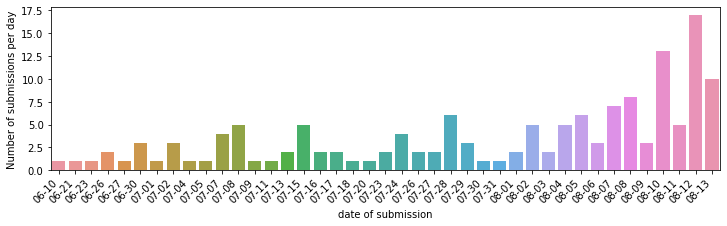

In [19]:
# Get submissions per day

## filter only submissions before deadline
filtered = df[df['timestamp'].dt.date < datetime.date(year=2021, month=8,day=14)]
days=filtered.groupby([filtered['timestamp'].dt.date]).mid.nunique().reset_index()

fig, ax = plt.subplots(figsize = (12,3), nrows=1, ncols=1)    
x_dates = filtered['timestamp'].dt.strftime('%m-%d').sort_values().unique()
fig = sns.barplot(x='timestamp', y="mid", data=days, ax=ax)
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.set(xlabel='date of submission', ylabel='Number of submissions per day')
plt.savefig("imgs/submissions.pdf",bbox_inches='tight')


# Analyze improvements per languages


In [27]:
def plot_langs(data, bycol="src", name="full"):
    longdesc={"src": "Source", "trg": "Target"}
    fig_width = {"full": 21, "task1":8, "task2": 8}
    fig, ax = plt.subplots(figsize = (fig_width[name],3), nrows=1, ncols=1)    
    sorted_data= data.groupby(bycol).perf.mean().sort_values(ascending=False)
    
    sns.barplot(data=data,x=bycol,y='perf',order=sorted_data.index, palette="crest")
    ax.set_xticklabels(labels=sorted_data.index, rotation=45, ha='right')
    ax.set(xlabel=f'{longdesc[bycol]} language', ylabel='delta in spBLEU')
    plt.savefig(f"imgs/analysis_{name}_langs_by_{bycol}.pdf",bbox_inches='tight')

    #fig.show()
               
        
def analyze_task(task):
    deltas = (
    #get delta of performance between highest and baseline
    df[df.mid.isin(allp[task])].groupby(['src','trg','mid']).perf.mean().reset_index().groupby(['src','trg']).perf.max()
        - df[df.mid.isin(baselines[task])].groupby(['src','trg']).perf.mean()

    ).reset_index()
    
    ################
    print("""***Analysis of language pairs deltas***""") 
    sorted_delta = deltas.sort_values(by='perf', ascending=False)
    print ("TOP 5 improvements wrt to baseline")
    print(sorted_delta[:5] )
    print ("BOTTOM 5 improvements wrt to baseline")
    print(sorted_delta[-5:] )

    print(f"GAP between top and bottom by pair: {list(sorted_delta.reset_index().perf)[0] -  list(sorted_delta.reset_index().perf)[-1]}" )
    
    print('AVG improv into ENG', deltas[deltas.trg=='eng'].perf.mean())
    
    print("""***Analysis per of averages source language***""")
    sorted_delta = deltas.groupby('src').mean().sort_values(by='perf', ascending=False)
    print ("TOP 5 improvements wrt to baseline")
    print(sorted_delta[:5] )
    print ("BOTTOM 5 improvements wrt to baseline")
    print(sorted_delta[-5:] )
    
    print(f"GAP between top and bottom by source: {list(sorted_delta.reset_index().perf)[0] -  list(sorted_delta.reset_index().perf)[-1]}" )

        
    print("""Analysis of averages per target language""")
    sorted_delta=deltas.groupby('trg').mean().sort_values(by='perf', ascending=False)
    print ("TOP 5 improvements wrt to baseline")
    print(sorted_delta[:5])
    print ("BOTTOM 5 improvements wrt to baseline")
    print(sorted_delta[-5:])
    print(f"GAP between top and bottom by trg: {list(sorted_delta.reset_index().perf)[0] -  list(sorted_delta.reset_index().perf)[-1]}" )

    plot_langs(deltas, bycol="src", name=task )
    plot_langs(deltas, bycol="trg", name=task)
    

               

## Full task analysis

***Analysis of language pairs deltas***
TOP 5 improvements wrt to baseline
      src  trg   perf
1832  eng  cym  45.81
2442  gle  eng  43.46
1841  eng  gle  42.96
5771  mlt  cym  42.20
2480  gle  mlt  41.97
BOTTOM 5 improvements wrt to baseline
            src  trg  perf
10042  zho_simp  kea   0.0
3678        ita  kea   0.0
1932        est  ckb   0.0
6810        oci  kea   0.0
830         bos  ful   0.0
GAP between top and bottom by pair: 45.81
AVG improv into ENG 17.73712871287129
***Analysis per of averages source language***
TOP 5 improvements wrt to baseline
          perf
src           
gle  19.730297
cym  17.444752
uzb  16.990099
npi  15.309406
guj  14.800891
BOTTOM 5 improvements wrt to baseline
         perf
src          
umb  2.950396
kam  2.827327
ckb  2.197129
ful  1.746535
yor  1.618911
GAP between top and bottom by source: 18.111386138613863
Analysis of averages per target language
TOP 5 improvements wrt to baseline
          perf
trg           
gle  26.205941
cym  25.9854

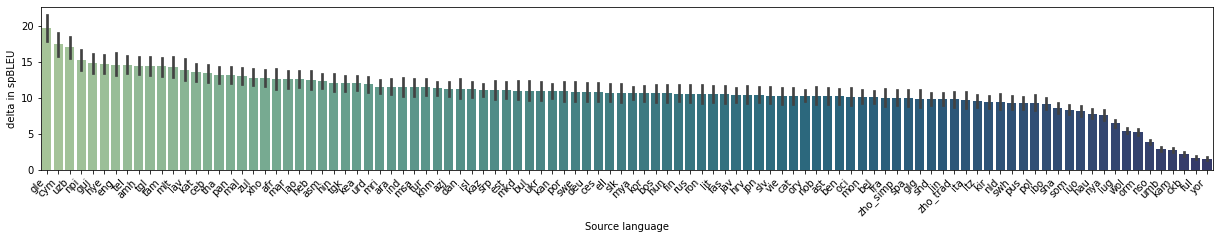

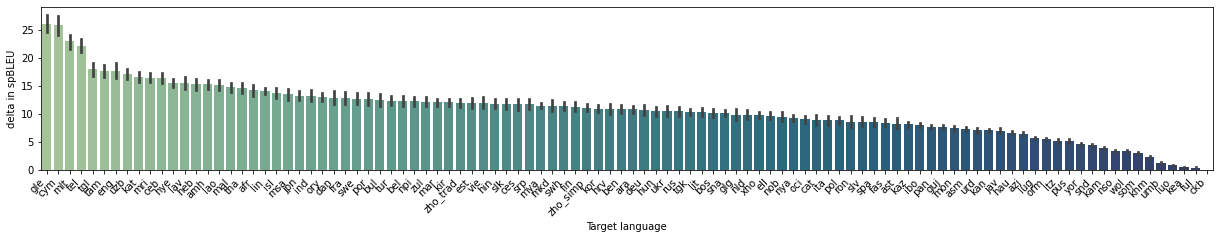

In [28]:
# full task
analyze_task("full")

# Task 1 analysis 

***Analysis of language pairs deltas***
TOP 5 improvements wrt to baseline
    src  trg   perf
4   eng  srp  18.87
25  srp  eng  14.89
5   est  eng  14.77
20  mkd  eng  14.28
0   eng  est  14.20
BOTTOM 5 improvements wrt to baseline
    src  trg  perf
14  hrv  srp  9.79
17  hun  hrv  9.42
22  mkd  hrv  7.09
13  hrv  mkd  6.84
27  srp  hrv  5.41
GAP between top and bottom by pair: 13.460000000000004
AVG improv into ENG 14.053999999999998
***Analysis per of averages source language***
TOP 5 improvements wrt to baseline
       perf
src        
eng  14.206
est  11.560
hun  11.462
mkd  11.396
srp  10.554
BOTTOM 5 improvements wrt to baseline
       perf
src        
est  11.560
hun  11.462
mkd  11.396
srp  10.554
hrv   9.924
GAP between top and bottom by source: 4.281999999999998
Analysis of averages per target language
TOP 5 improvements wrt to baseline
       perf
trg        
eng  14.054
srp  13.116
est  11.674
hun  11.232
mkd  10.246
BOTTOM 5 improvements wrt to baseline
       perf
trg  

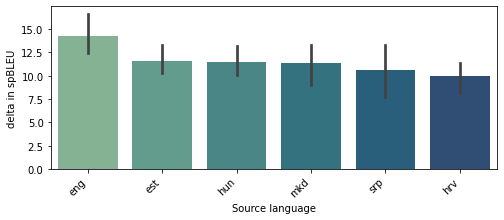

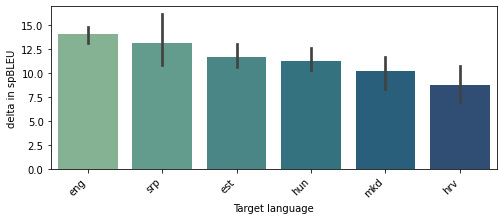

In [29]:

analyze_task("task1")

***Analysis of language pairs deltas***
TOP 5 improvements wrt to baseline
    src  trg   perf
3   eng  tam  31.95
20  tam  eng  30.67
25  tgl  eng  30.42
4   eng  tgl  30.12
8   ind  tam  28.75
BOTTOM 5 improvements wrt to baseline
    src  trg   perf
27  tgl  jav  15.15
17  msa  jav  13.90
7   ind  msa  12.92
16  msa  ind  11.72
6   ind  jav  11.71
GAP between top and bottom by pair: 20.239999999999995
AVG improv into ENG 25.816000000000003
***Analysis per of averages source language***
TOP 5 improvements wrt to baseline
       perf
src        
eng  24.904
tam  24.262
tgl  23.824
jav  21.142
ind  20.008
BOTTOM 5 improvements wrt to baseline
       perf
src        
tam  24.262
tgl  23.824
jav  21.142
ind  20.008
msa  19.642
GAP between top and bottom by source: 5.261999999999997
Analysis of averages per target language
TOP 5 improvements wrt to baseline
       perf
trg        
tam  27.302
eng  25.816
tgl  25.200
msa  20.162
ind  20.050
BOTTOM 5 improvements wrt to baseline
       perf

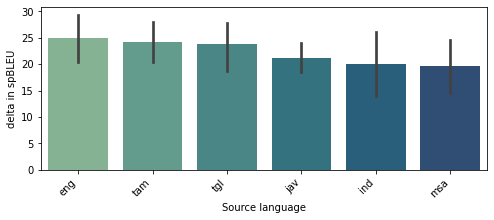

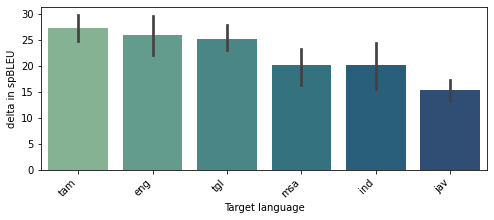

In [30]:
# task2 task
analyze_task("task2")

In [31]:
def contrast_mm(data, task='task1', bycol='src'):
    longdesc={"src": "Source", "trg": "Target"}
    fig_width = {"full": 21, "task1":8, "task2": 8}
    fig, ax = plt.subplots(figsize = (fig_width[task],3), nrows=1, ncols=1)    
    comparison=data[(data.mid.isin(winners['full']+winners[task]) ) & (data.src.isin(languages[task]) ) & (data.trg.isin(languages[task]) )]
    sorted_data= comparison.groupby(bycol).perf.mean().sort_index(ascending=True)

    sns.barplot(data=comparison, x=bycol, y="perf", hue="taskname")
    ax.set_xticklabels(labels=sorted_data.index, rotation=45, ha='right')

    ax.set(xlabel=f'{longdesc[bycol]} language', ylabel='Winning model spBLEU')
    plt.legend(title='Shared Task')
    plt.savefig(f"imgs/analysis_full_vs_{task}_contrast_by_{bycol}.pdf",bbox_inches='tight')

def analyze_contrast(task):
    contrast_mm(df,task, "src")
    contrast_mm(df,task, "trg")
    

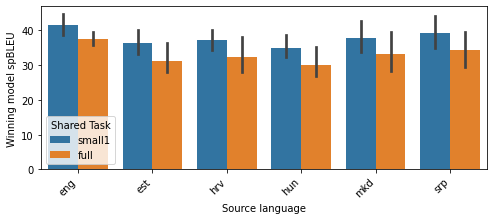

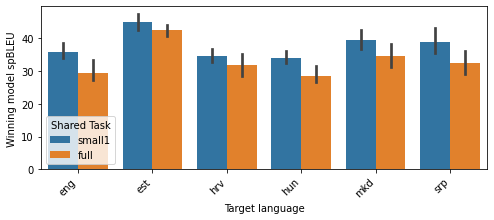

In [32]:

analyze_contrast("task1")

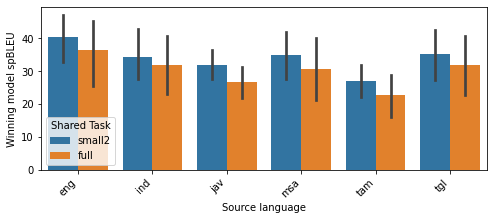

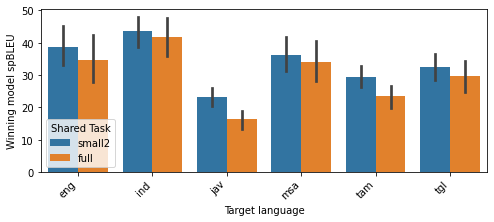

In [33]:
analyze_contrast("task2")